In [1]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob


import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

In [2]:
# Load configuration
with open("../../config/config_notebooks_HER2.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

In [3]:
import math
def make_spider(df, row, color, title, min=0, max=1):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5))
 
    ax = plt.subplot(1,1,1, polar=True)
 
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
 
   
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    
    tick_values = np.linspace(min, max, 5)
    tick_strings = [f"{value:.2e}" for value in tick_values]
    plt.yticks(tick_values, tick_strings, color="black", size=10)
    plt.ylim(min, max)
 
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.1)
 
  
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)

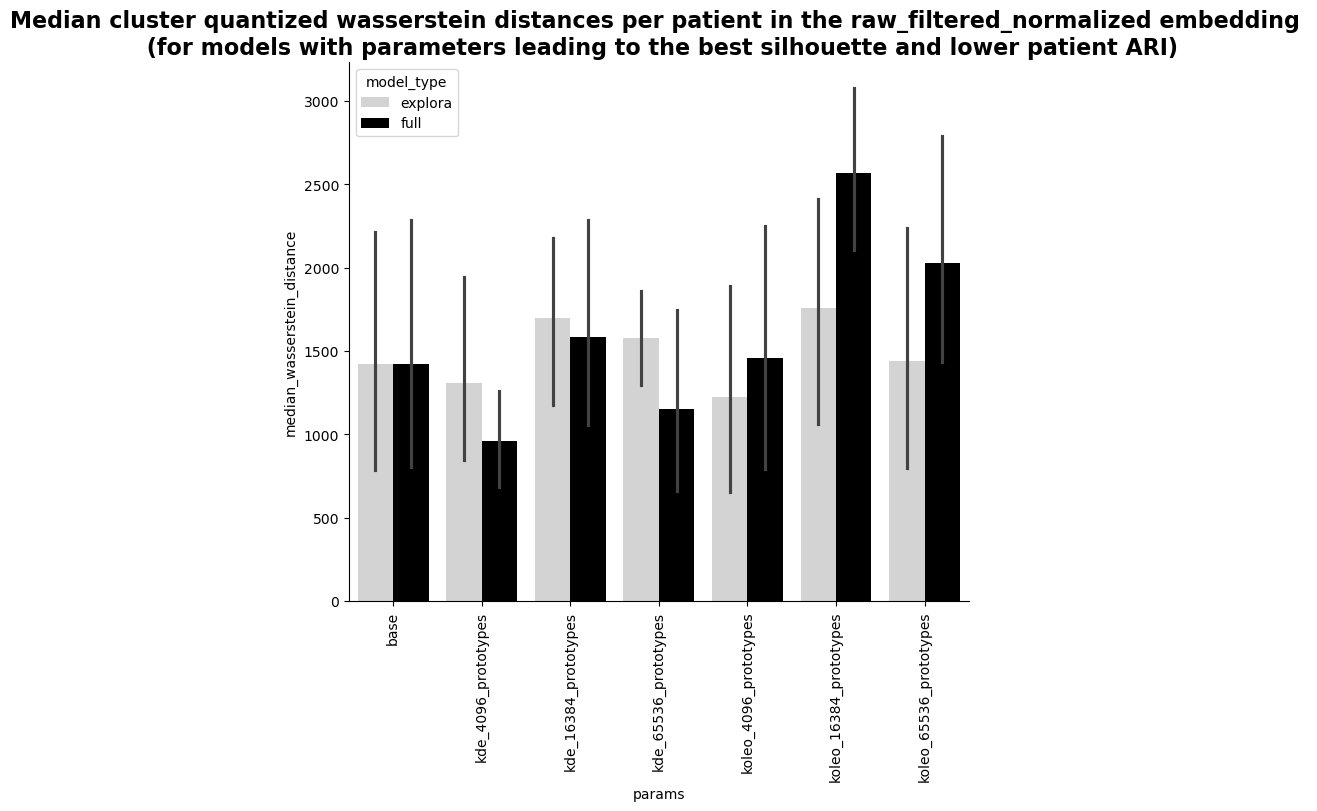

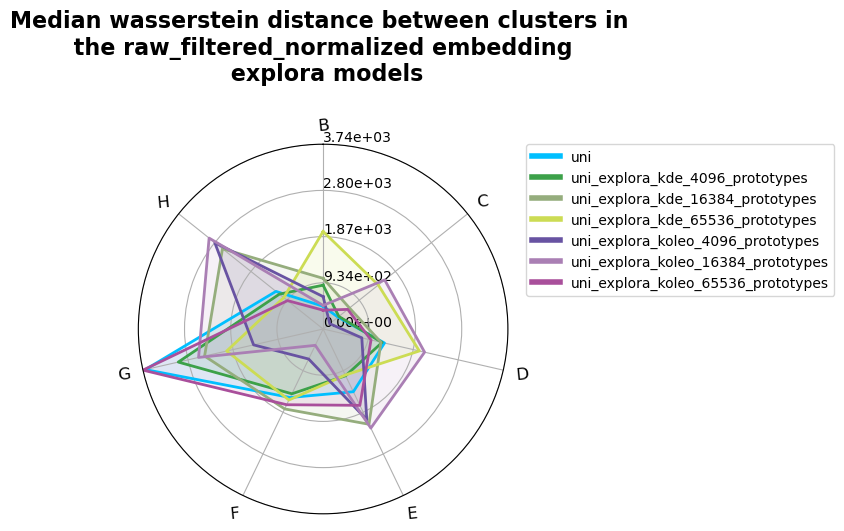

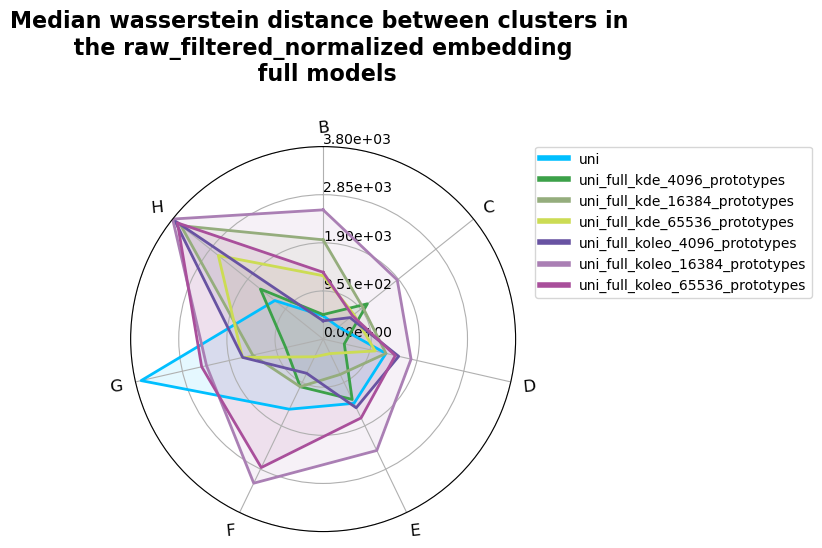

In [4]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(["B", "C", "D", "E", "F", "G", "H"]):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []

    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "opti_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        


        for name in names:

            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)


            mean_wasserstein_distance = np.mean(wasserstein_distances)
            std_wasserstein_distance = np.std(wasserstein_distances)
            median_wasserstein_distance = np.median(wasserstein_distances)

            min_wasserstein_distance = np.min(wasserstein_distances)
            max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")

df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
plt.figure(figsize=(8, 7))
sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
plt.xticks(rotation=90)
sns.despine()

plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
#plt.yscale("log")
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_raw_filtered_normalized_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()

for model_type, names in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']]):
    plt.figure()
    for j, name in enumerate(names):
        if name == "uni":
            name = f"uni_{model_type}"
        d_s = df_spider[(df_spider['model'] == name) & (df_spider['model_type'] == model_type)].set_index("patient").T
        make_spider(d_s, row=5, color=a[j], title=name, min=0, max=df_spider[(df_spider['model_type'] == model_type)]['median_wasserstein_distance'].max())
       # make_spider(d_s, row=3, color=models_palette[j], title=name, min=0, max=40000)

        # print(name)

        handles = [plt.Line2D([0], [0], color=a[i], lw=4) for i in range(len(names))]
        plt.legend(handles, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    plt.title(f"Median wasserstein distance between clusters in \n the raw_filtered_normalized embedding \n {model_type} models", y=1.15, weight='bold', fontsize=16)
    plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_normalized_embedding_per_patient_{model_type}.pdf"), bbox_inches='tight')

In [5]:
optimal_clusters = optimal_clusters.reset_index().drop_duplicates(["name"]).set_index("name")

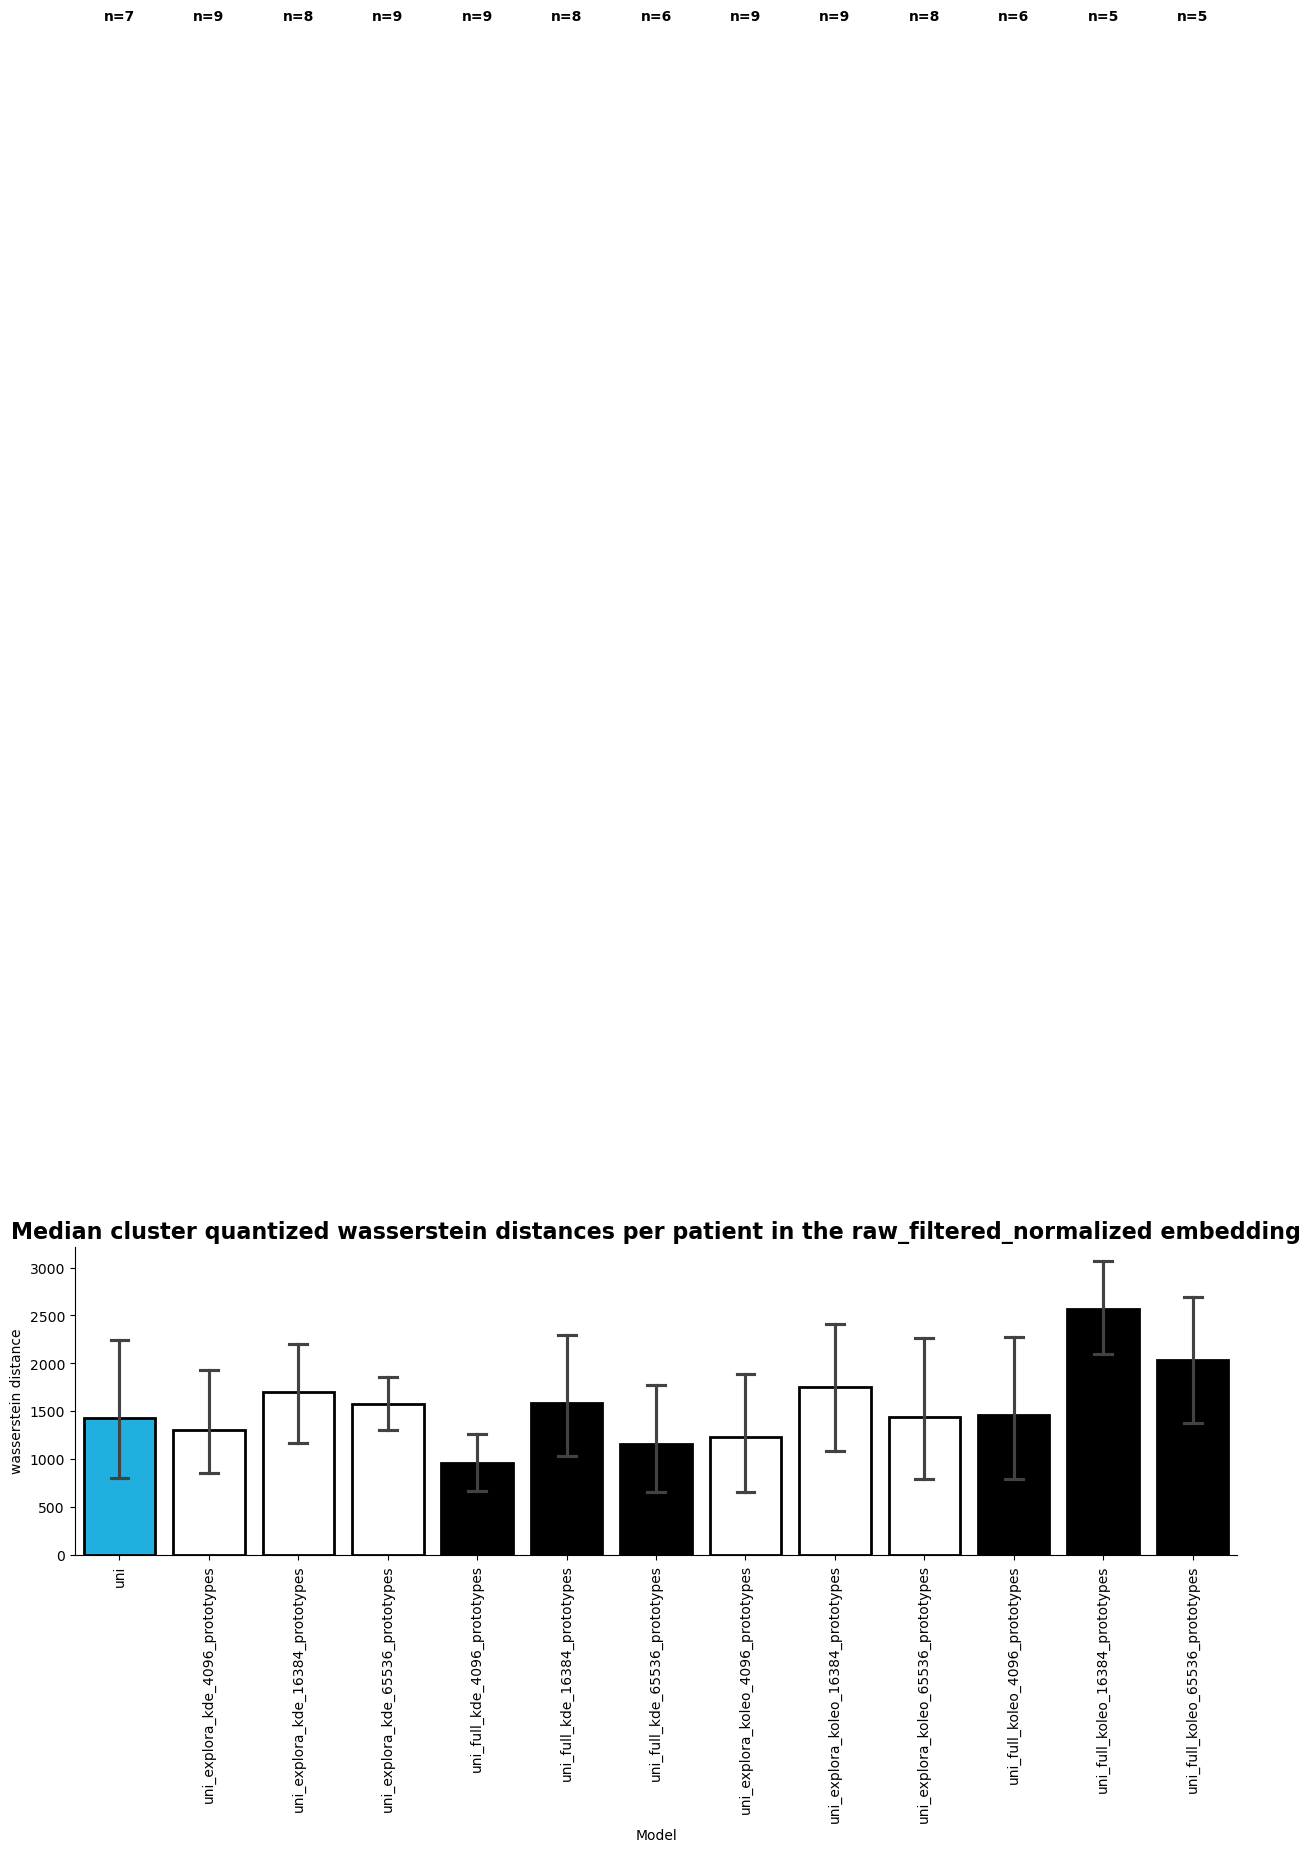

In [6]:
dfs = []
n_clusters = []
for model_type in ["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_16384_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_16384_prototypes",
                "uni_full_koleo_65536_prototypes"]:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n = optimal_clusters.loc[model_type, 'n_clusters']
    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=["deepskyblue", 
         "white", "white", "white", 
         "black", "black", "black", 
         "white", "white", "white", 
         "black", "black","black", ], 
# palette=["deepskyblue", "white", "white", "white","black", 
#           "black", "black", "white", "white", "white", 
#         "black", "black", "black", ],
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=16000, s=f"n={n}", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw filtered_embedding_per_patient.pdf"), bbox_inches='tight')

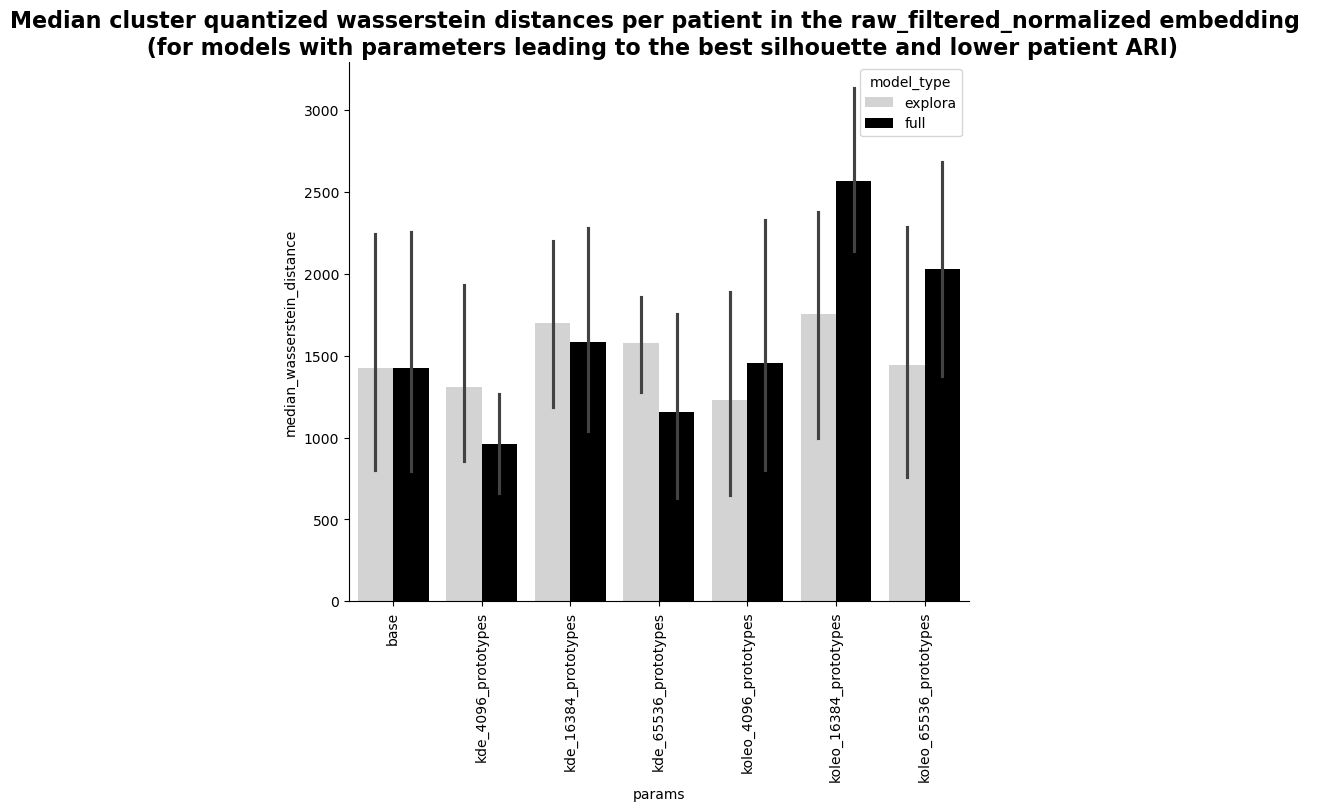

In [7]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(["B", "C", "D", "E", "F", "G", "H"]):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []


    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "opti_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        
        


        for name in names:

            # print(f"model_type: {name}, optimal clusters: {opti_clusters.loc[name, 'n_clusters']}")

            
        # print(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv"))
            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_normalized_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)


            mean_wasserstein_distance = np.mean(wasserstein_distances)
            std_wasserstein_distance = np.std(wasserstein_distances)
            median_wasserstein_distance = np.median(wasserstein_distances)

            min_wasserstein_distance = np.min(wasserstein_distances)
            max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
plt.figure(figsize=(8, 7))
sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
plt.xticks(rotation=90)
sns.despine()

plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
#plt.yscale("log")
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_raw_filtered_normalized_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()




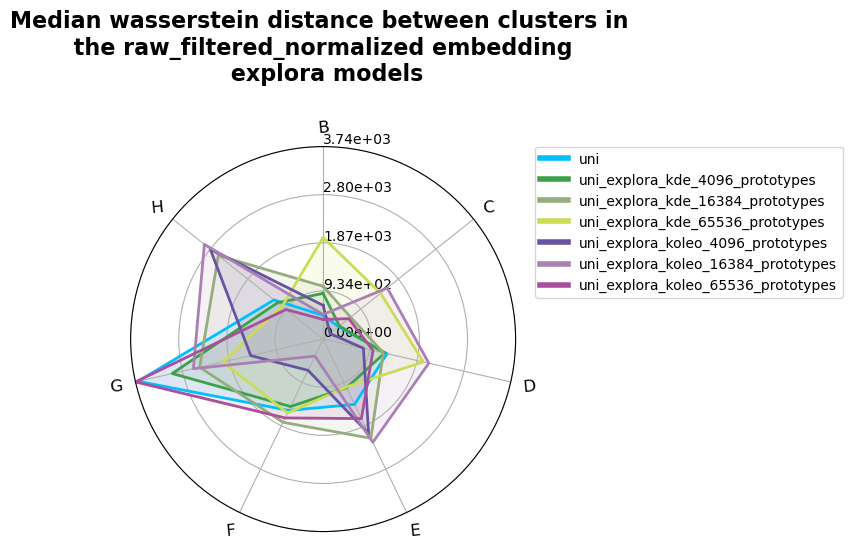

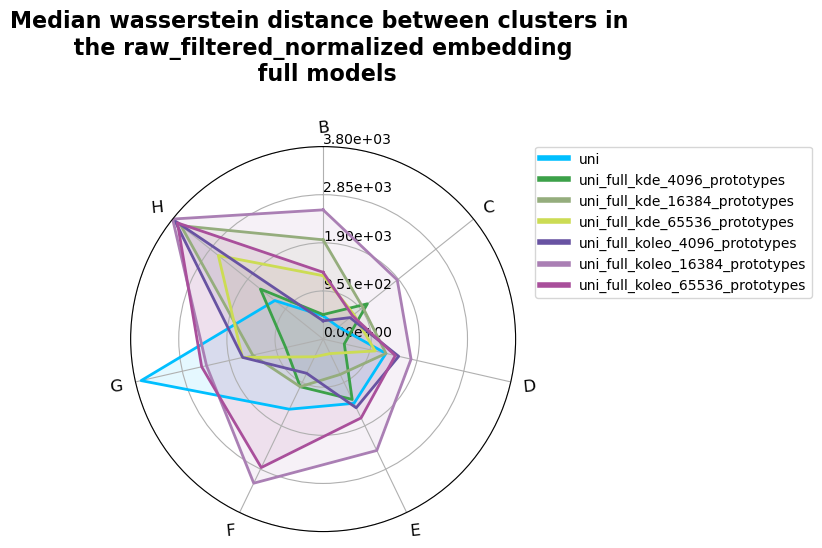

In [8]:
for model_type, names in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']]):
    plt.figure()
    for j, name in enumerate(names):
        if name == "uni":
            name = f"uni_{model_type}"
        d_s = df_spider[(df_spider['model'] == name) & (df_spider['model_type'] == model_type)].set_index("patient").T
        make_spider(d_s, row=5, color=a[j], title=name, min=0, max=df_spider[(df_spider['model_type'] == model_type)]['median_wasserstein_distance'].max())
       # make_spider(d_s, row=3, color=models_palette[j], title=name, min=0, max=40000)

        # print(name)

        handles = [plt.Line2D([0], [0], color=a[i], lw=4) for i in range(len(names))]
        plt.legend(handles, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    plt.title(f"Median wasserstein distance between clusters in \n the raw_filtered_normalized embedding \n {model_type} models", y=1.15, weight='bold', fontsize=16)
    plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_normalized_embedding_per_patient_{model_type}.pdf"), bbox_inches='tight')



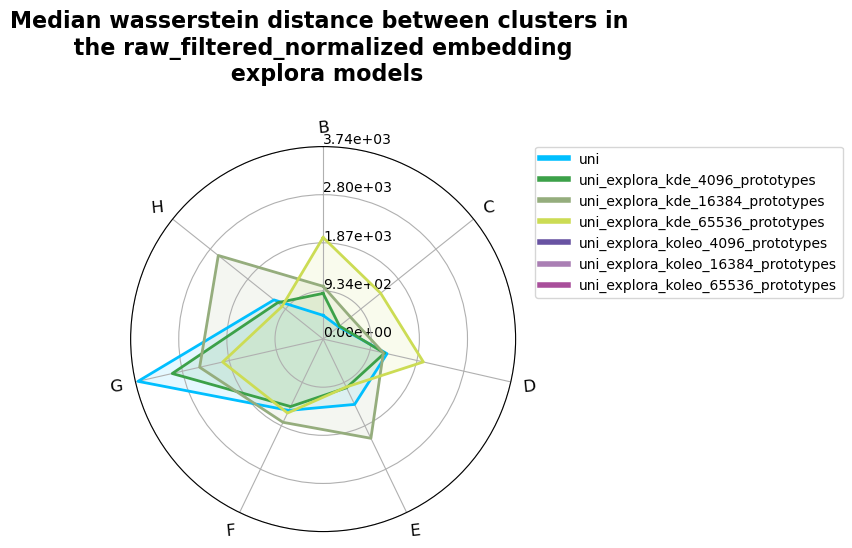

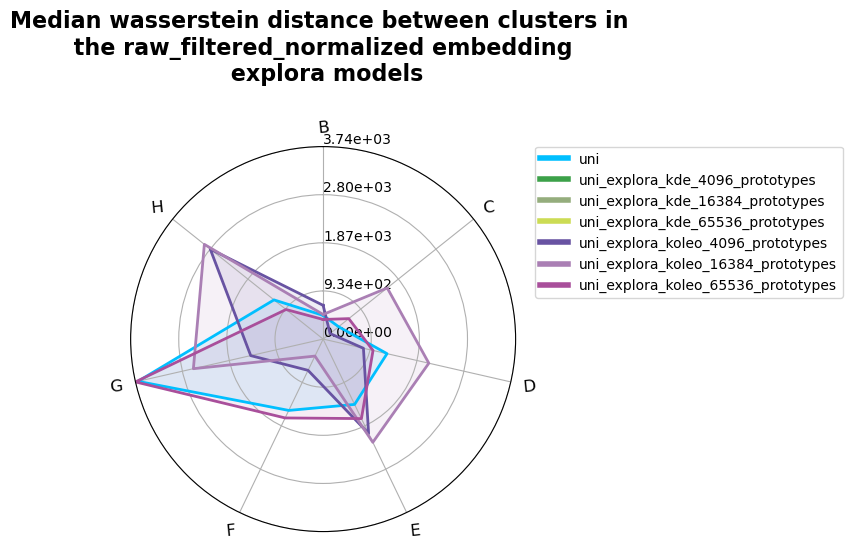

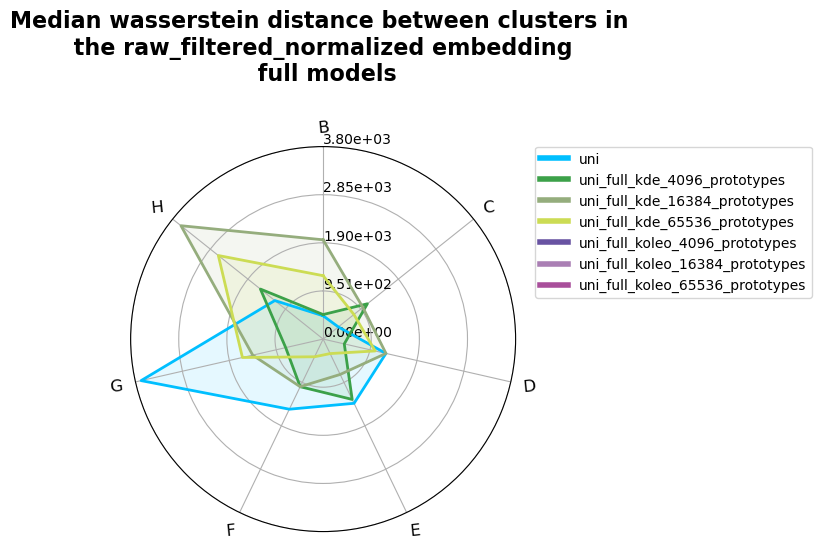

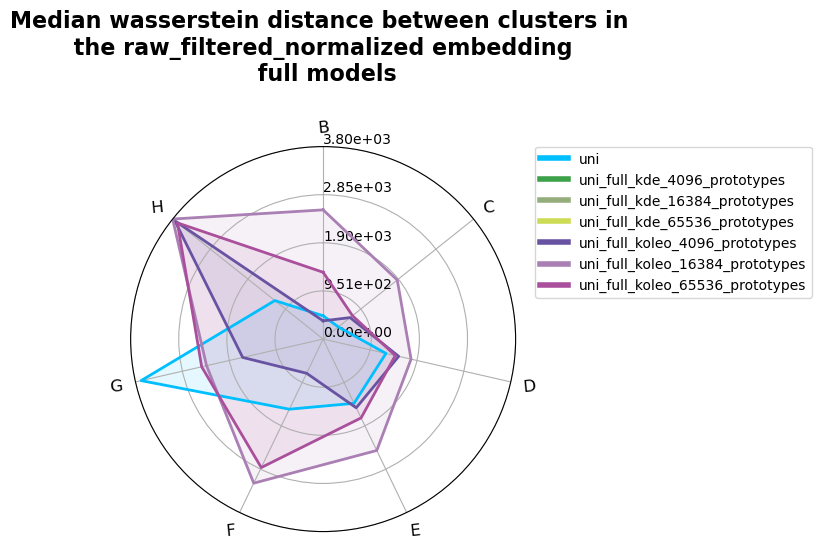

In [9]:
for model_type, names in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']]):
    for loss in ["kde", "koleo"]:
        plt.figure()
        for j, name in enumerate(names):
            if name == "uni":
                name = f"uni_{model_type}"
            if (loss in name) or (name == f"uni_{model_type}"):
                d_s = df_spider[(df_spider['model'] == name) & (df_spider['model_type'] == model_type)].set_index("patient").T
                make_spider(d_s, row=5, color=a[j], title=name, min=0, max=df_spider[(df_spider['model_type'] == model_type)]['median_wasserstein_distance'].max())
            # make_spider(d_s, row=3, color=models_palette[j], title=name, min=0, max=40000)

                # print(name)

                handles = [plt.Line2D([0], [0], color=a[i], lw=4) for i in range(len(names))]
                plt.legend(handles, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        plt.title(f"Median wasserstein distance between clusters in \n the raw_filtered_normalized embedding \n {model_type} models", y=1.15, weight='bold', fontsize=16)
        plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_normalized_embedding_per_patient_{model_type}.pdf"), bbox_inches='tight')


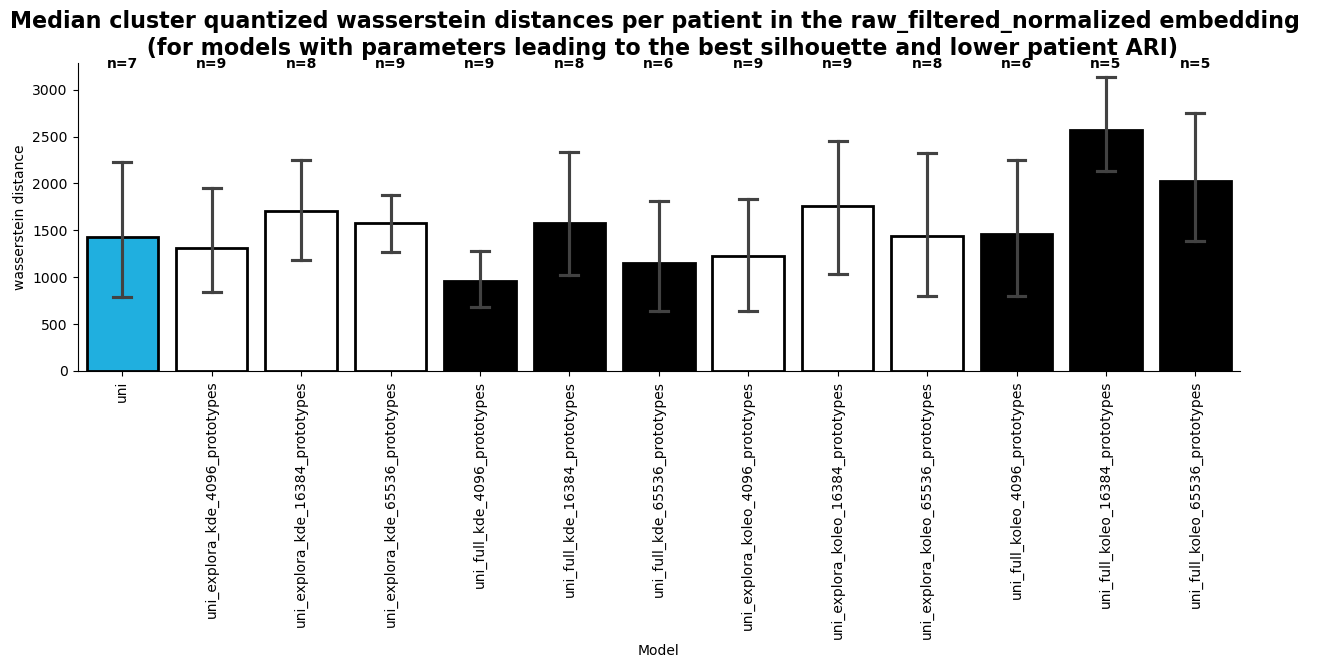

In [27]:
dfs = []
n_clusters = []
for model_type in ["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_16384_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_16384_prototypes",
                "uni_full_koleo_65536_prototypes"]:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=["deepskyblue", "white", "white", "white",
         "black", "black","black",
         "white", "white", "white",
         "black", "black","black", ], 
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered_normalized embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=3200, s=f"n={int(n)}", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_normalized_embedding_per_patient.pdf"), bbox_inches='tight')

In [11]:
uni_distances = df[df["model"] == "uni"]["wasserstein_distances"].values
# Flatten the nested arrays completely
uni_distances = np.concatenate(uni_distances)

t_uni_distances = np.concatenate(df[df["model"] == "uni_full_koleo_65536_prototypes"]["wasserstein_distances"].values)

print(f"UNI: {len(uni_distances)} ;  T-UNI: {len(t_uni_distances)}")

UNI: 135 ;  T-UNI: 58


In [12]:
df[df["model"] == "uni_full_koleo_16384_prototypes"]

,model,n_clusters,wasserstein_distances,mean_wasserstein_distance,std_wasserstein_distance,median_wasserstein_distance,min_wasserstein_distance,max_wasserstein_distance,model_type,params,patient
77,uni_full_koleo_16384_prototypes,3,"[2295.3411970717634, 2552.21330187644, 3051.62...",2633.060062,313.999689,2552.213302,2295.341197,3051.625689,full,koleo_16384_prototypes,B
78,uni_full_koleo_16384_prototypes,3,"[1872.5367781921575, 1036.93682874837, 1946.18...",1618.551999,412.361552,1872.536778,1036.936829,1946.182391,full,koleo_16384_prototypes,C
79,uni_full_koleo_16384_prototypes,5,"[575.3856284243707, 318.12195847216515, 850.32...",1617.428087,794.415064,1781.519668,318.121958,3135.935061,full,koleo_16384_prototypes,D
80,uni_full_koleo_16384_prototypes,5,"[2197.2829703360585, 2387.290686365075, 4260.4...",2726.317521,1078.044271,2442.202093,558.396360,4260.468628,full,koleo_16384_prototypes,E
81,uni_full_koleo_16384_prototypes,5,"[1310.404750505914, 2962.54037656382, 3628.910...",2944.961309,1069.010231,3159.148994,1310.404751,4933.646727,full,koleo_16384_prototypes,F
82,uni_full_koleo_16384_prototypes,5,"[396.1581836195119, 1681.306605137185, 1923.14...",2651.729615,1293.308939,2361.747625,396.158184,4589.438364,full,koleo_16384_prototypes,G
83,uni_full_koleo_16384_prototypes,5,"[3712.444810655381, 3334.7734287494395, 1133.8...",4102.973132,1443.985842,3802.186555,1133.875834,6045.328955,full,koleo_16384_prototypes,H


In [13]:
df[df["model"] == "uni"]

,model,n_clusters,wasserstein_distances,mean_wasserstein_distance,std_wasserstein_distance,median_wasserstein_distance,min_wasserstein_distance,max_wasserstein_distance,model_type,params,patient
0,uni,6,"[321.359375, 139.826416015625, 460.29907226562...",913.395247,848.435352,460.299072,129.614258,2238.576660,explora,base,B
1,uni,6,"[154.076904296875, 117.672119140625, 175.40136...",672.955404,528.185377,384.400391,117.672119,1608.653076,explora,base,C
2,uni,7,"[289.68510059740095, 146.29667152684823, 197.7...",1236.497413,793.085125,1272.934614,146.296672,2958.253906,explora,base,D
3,uni,7,"[170.9419404634553, 955.8336125657592, 1033.40...",1657.088975,885.683708,1408.105107,170.941940,3390.086995,explora,base,E
4,uni,7,"[96.83259633663477, 309.99465902845213, 283.89...",1479.946819,1107.287561,1537.436266,96.832596,3885.285289,explora,base,F
5,uni,7,"[1740.4282841970228, 3642.5191196986607, 1923....",3695.847193,1306.591556,3687.722108,1049.312423,6045.681958,explora,base,G
6,uni,7,"[486.8232942685262, 757.5026185937942, 833.626...",1777.360814,1290.011771,1220.230824,274.660343,4125.074219,explora,base,H


In [14]:
df_summary = pd.DataFrame(columns=["n_clusters", 
                                   "wasserstein_distances", 
                                   "mean_wasserstein_distance", 
                                   "std_wasserstein_distance", 
                                   "median_wasserstein_distance", 
                                   "min_wasserstein_distance", 
                                   "max_wasserstein_distance",
                                   "model_type",
                                   "params"])
summary_list = []
all_names = []
wassersteins = []
optimal_clusters = pd.DataFrame()
for model_type, names, path in zip([config['retrained_model_list1_type'],
                             config['retrained_model_list2_type']],
                             [config['retrained_model_list1'],
                              config['retrained_model_list2']],
                              [config['retrained_benchmark_folder1'],
                               config['retrained_benchmark_folder2']]):
    
    path_to_invasive_cancer_clustering_results = os.path.join(path, "invasive_cancer_clustering", config['invasive_cancer_clustering_algo'])
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "opti_clusters.csv"), index_col=0)
    dfs = []

    
    


    for name in names:
        # print(os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        # filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_raw_filtered_normalized_5_clusters.csv")
        filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_raw_filtered_normalized_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv")
        # filename = filenames[0]
        
        df = pd.read_csv(filename, index_col=0)

        n = opti_clusters.loc[name, 'n_clusters']
        optimal_clusters.loc[name, 'n_clusters'] = n

        n_clusters = df.shape[0]      
        # Get the lower triangular part of the matrix without the diagonal values
        lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
        wasserstein_distances = lower_matrix.stack().values
        wassersteins.append(wasserstein_distances)


        mean_wasserstein_distance = np.mean(wasserstein_distances)
        std_wasserstein_distance = np.std(wasserstein_distances)
        median_wasserstein_distance = np.median(wasserstein_distances)

        min_wasserstein_distance = np.min(wasserstein_distances)
        max_wasserstein_distance = np.max(wasserstein_distances)

        if name == "uni":
            params = "base"
        else:
            params = "_".join(name.split("_")[2:])

        summary_list.append({"n_clusters": n_clusters, 
                            "wasserstein_distances": wasserstein_distances, 
                            "mean_wasserstein_distance": mean_wasserstein_distance, 
                            "std_wasserstein_distance": std_wasserstein_distance, 
                            "median_wasserstein_distance": median_wasserstein_distance, 
                            "min_wasserstein_distance": min_wasserstein_distance, 
                            "max_wasserstein_distance": max_wasserstein_distance,
                            "model_type": model_type, 
                            "params": params})
        
        if name == "uni":
            name = f"uni_{model_type}"

        dfs.append(df)
        all_names.append(name)

df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
df_summary.index = all_names




df_sink = pd.DataFrame(wassersteins, index=all_names).T
df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


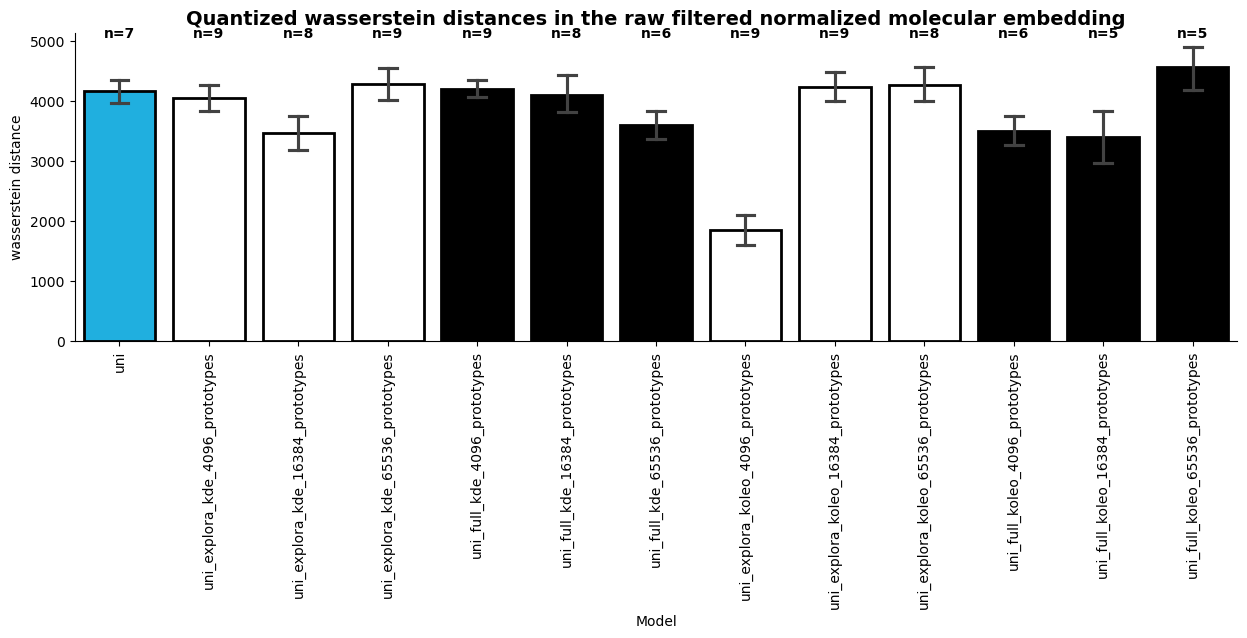

In [19]:


dfs = []
n_clusters = []

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])
for model_type in sorted_models:
    if model_type == "uni":
        df = df_sink_melted[df_sink_melted['model'] == "uni_explora"]
        df['model'] = "uni"
        n_clusters.append(df_summary.loc['uni_explora', 'n_clusters'])
    else:
        df = df_sink_melted[df_sink_melted['model'] == model_type]
        n_clusters.append(df_summary.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)


palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', 
            y="wasserstein_distance", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the raw filtered normalized molecular embedding", weight="bold", fontsize=14)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=5000, s=f"n={n}", ha='center', va='bottom', weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_molecular_raw_filtered_normalized_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")

In [20]:
from sklearn.metrics import adjusted_rand_score

aris_no_bootstrap = {}
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                config['retrained_model_list2_type']],
                                [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

    
    
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "opti_clusters.csv"), index_col=0)
    dfs = []
    optimal_clusters.append(opti_clusters)
    
    for name in names:
        n_clusters = opti_clusters.loc[name, 'n_clusters']

        labels_file = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans",
                                        name, 
                                        f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]
        labels = pd.read_csv(labels_file, index_col=0)
        labels['patient_id'] = labels.index.str.split('_').str[0]
        ari = adjusted_rand_score(labels['predicted_label'],
                                  labels['patient_id'])
        aris_no_bootstrap[name] = 1-ari

Text(0.5, 1.0, 'Total batch effect mitigation score (no bootstrap) \n in invasive clusters')

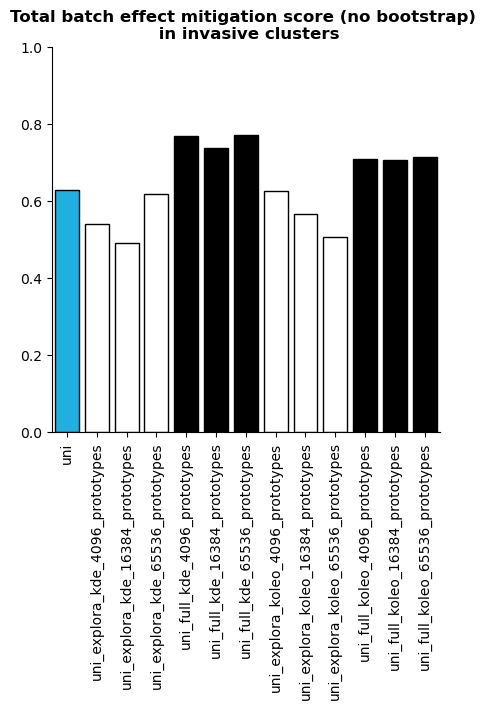

In [21]:
sns.barplot(aris_no_bootstrap, order=sorted_models, palette=palette, edgecolor='black')
plt.xticks(rotation=90)
sns.despine()
plt.ylim(0,1)
plt.title(f"Total batch effect mitigation score (no bootstrap) \n in invasive clusters", weight="bold")

In [22]:
max(aris_no_bootstrap.values()) - min(aris_no_bootstrap.values())


0.2790021213788817